In [146]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff


from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch
from spacy.training.example import Example
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shahy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [63]:
def random_colours(number_of_colors):
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors


In [64]:
random_colours(5)

['#05F74B', '#EFC9AF', '#7793E7', '#1D5108', '#E822E5']

In [65]:
x = ''.join([random.choice('0123456789ABCDEF') for j in range(6)])

In [66]:
test_data = pd.read_csv('test.csv')
train_data = pd.read_csv('train.csv')
submission = pd.read_csv('sample_submission.csv')

In [67]:
test_data.head(3)

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative


In [68]:
train_data.head(3)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative


In [69]:
submission.head(3)

,textID,selected_text
0,f87dea47db,NaN
1,96d74cb729,NaN
2,eee518ae67,NaN


In [70]:
train_data.describe()

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11118


In [71]:
train_data['sentiment'].value_counts()

neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [72]:
train_data.groupby('sentiment').count()['text'].sort_values(ascending = False)

sentiment
neutral     11117
positive     8582
negative     7781
Name: text, dtype: int64

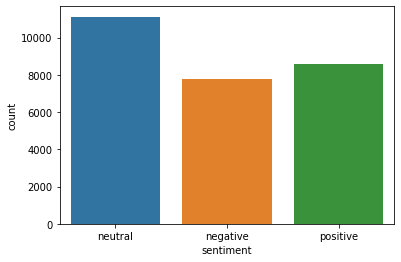

In [73]:
sns.countplot(x= 'sentiment', data=train_data)

In [74]:
def jaccard(input1, input2): 
    if type(input1) or type(input2)== float:
        input1 = str(input1)
        input2 = str(input2)
    a = set(input1.lower().split())
    b = set(input2.lower().split())
    c = a.intersection(b)
    return len(c) / (len(a) + len(b) - len(c))

In [75]:
results_jaccard=[]

for ind,row in train_data.iterrows():
    sentence1 = row.text
    sentence2 = row.selected_text
    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [76]:
# count = 0
# for ind,row in train_data.iterrows():
#     sentence1 = row.text
#     sentence2 = row.selected_text
#     count +=1
#     if count ==1:
#         print(sentence1, sentence2)

In [77]:
len(results_jaccard[0])

3

In [78]:
result_with_jaccard = pd.DataFrame(results_jaccard, columns=["text","selected_text","jaccard_score"])

In [79]:
#result_with_jaccard.rename(columns = {0:'text',1:'selected_text',2:'jaccard_score'}, inplace = True)

In [80]:
result_with_jaccard.head(2)

,text,selected_text,jaccard_score
0,"I`d have responded, if I were going","I`d have responded, if I were going",1.0
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,0.2


In [81]:
combined_dataset = train_data.merge(result_with_jaccard, how = 'outer')

In [82]:
combined_dataset.head(2)

,textID,text,selected_text,sentiment,jaccard_score
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.2


In [83]:
#filter_data = filter(combined_dataset['jaccard_score'] > 0.5, combined_dataset)

In [84]:
combined_dataset[combined_dataset['jaccard_score'] >= 0.5]

,textID,text,selected_text,sentiment,jaccard_score
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,1.000000
7,50e14c0bb8,Soooo high,Soooo high,neutral,1.000000
8,e050245fbd,Both of you,Both of you,neutral,1.000000
...,...,...,...,...,...
27469,ac92790d8b,94 more days till BH comes back to LA,94 more days till BH comes back to LA,neutral,1.000000
27471,15bb120f57,"i`m defying gravity. and nobody in alll of oz,...","i`m defying gravity. and nobody in alll of oz,...",neutral,1.000000
27473,a208770a32,in spoke to you yesterday and u didnt respond...,in spoke to you yesterday and u didnt respond ...,neutral,1.000000
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,1.000000


In [85]:
combined_dataset['length of text'] = combined_dataset['text'].apply(lambda x: len(str(x).split()))

In [86]:
combined_dataset['length of selected text'] = combined_dataset['selected_text'].apply(lambda x: len(str(x).split()))

In [87]:
combined_dataset['difference'] = combined_dataset['length of text'] - combined_dataset['length of selected text']

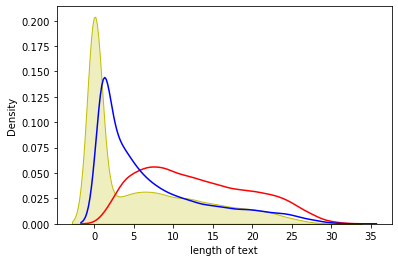

In [88]:
p1 = sns.kdeplot(combined_dataset['length of text'], shade = None, color = 'r')
p2 = sns. kdeplot(combined_dataset['length of selected text'], shade = None, color = 'b')
p3 = sns.kdeplot(combined_dataset['difference'], shade = 'fill' , color = 'y')

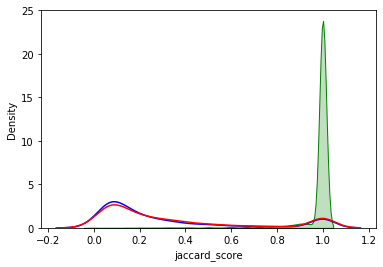

In [89]:
p4 = sns.kdeplot(combined_dataset[combined_dataset['sentiment']=='positive']['jaccard_score'], shade = None, color = 'b')
p5 = sns.kdeplot(combined_dataset[combined_dataset['sentiment']=='negative']['jaccard_score'], shade = None, color = 'r')
p6 = sns.kdeplot(combined_dataset[combined_dataset['sentiment']=='neutral']['jaccard_score'], shade = 'fill', color = 'g')

#as you can see that the neutral tweets have a score of one mostly stating that the length of text is the same. 

In [90]:
#cleaning the dataset from all the irrelevant comments:

def clean_data(comment):
    text = str(comment).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [91]:
def stopword_removal(text):
    return [words for words in text if words not in stopwords.words('english')]

In [92]:
input1 = 'wh?at the lu@ck!!'
clean_data(input1)

'what the luck'

In [93]:
combined_dataset['text'] = combined_dataset['text'].apply(lambda x: clean_data(x)) 
combined_dataset['selected_text'] = combined_dataset['selected_text'].apply(lambda x: clean_data(x)) 

In [94]:
combined_dataset['words'] = combined_dataset['selected_text'].apply(lambda x: x.split())
combined_dataset['words'] = combined_dataset['words'].apply(lambda x: stopword_removal(x))

In [95]:
combined_dataset.head(3)

,textID,text,selected_text,sentiment,jaccard_score,length of text,length of selected text,difference,words
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,1.000000,7,7,0,"[id, responded, going]"
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,0.200000,10,2,8,"[sooo, sad]"
2,088c60f138,my boss is bullying me,bullying me,negative,0.166667,5,2,3,[bullying]


In [96]:
counter_dictionary = Counter([items_counter for items in combined_dataset['words'] for items_counter in items])

In [97]:
database = pd.DataFrame(counter_dictionary.most_common(25), columns = ['words','count'])

In [98]:
database.shape

(25, 2)

In [99]:
database = database.iloc[1:,:]

In [100]:
#now do the same thing for text
combined_dataset['text_words'] = combined_dataset['text'].apply(lambda x: x.split())
combined_dataset['text_words'] = combined_dataset['text_words'].apply(lambda x: stopword_removal(x))

In [101]:
#for visualization
counter_dict_text = Counter([items_counter for items in combined_dataset['text_words'] for items_counter in items])
database_text = pd.DataFrame(counter_dict_text.most_common(25), columns = ['words','count'])

In [102]:
combined_dataset.tail(3)

,textID,text,selected_text,sentiment,jaccard_score,length of text,length of selected text,difference,words,text_words
27478,f67aae2310,yay good for both of you enjoy the break you...,yay good for both of you,positive,0.272727,22,6,16,"[yay, good]","[yay, good, enjoy, break, probably, need, hect..."
27479,ed167662a5,but it was worth it,but it was worth it,positive,1.000000,6,6,0,[worth],[worth]
27480,6f7127d9d7,all this flirting going on the atg smiles ...,all this flirting going on the atg smiles yay...,neutral,0.833333,11,11,0,"[flirting, going, atg, smiles, yay, hugs]","[flirting, going, atg, smiles, yay, hugs]"


In [103]:
database_text = database_text.iloc[1:,:] 

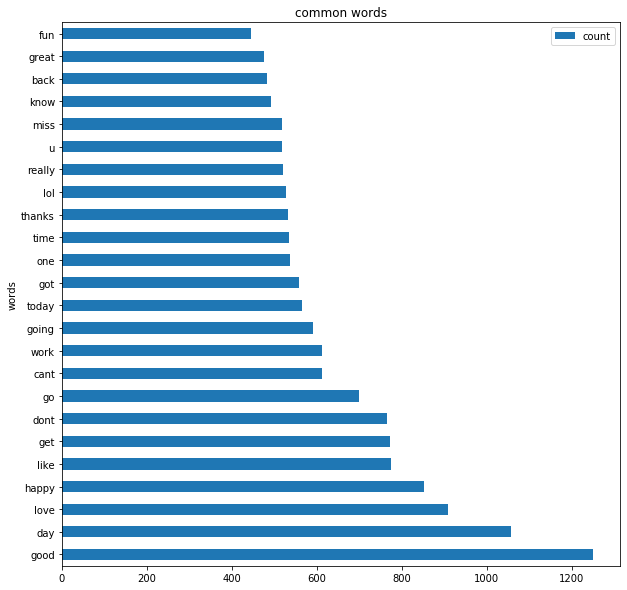

In [104]:
#for visualization bar plot:
#fig = px.treemap(database, path=['words'], values='count',title='Tree of Most Common Words')
#fig.show()
database.plot.barh('words', 'count', title = 'common words', figsize= (10,10))

In [105]:
positive_senti_dataset = combined_dataset[combined_dataset['sentiment']=='positive']
negative_senti_dataset = combined_dataset[combined_dataset['sentiment']=='negative']
neutral_senti_dataset = combined_dataset[combined_dataset['sentiment']=='neutral']

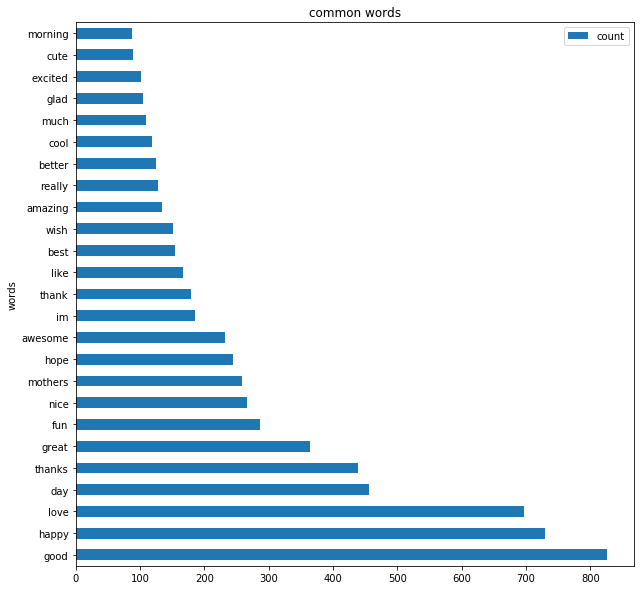

In [106]:
#for positive visualization
counter_dict_text = Counter([items_counter for items in positive_senti_dataset['words'] for items_counter in items])
database_positive = pd.DataFrame(counter_dict_text.most_common(25), columns = ['words','count'])
database_positive.plot.barh('words', 'count', title = 'common words', figsize= (10,10))

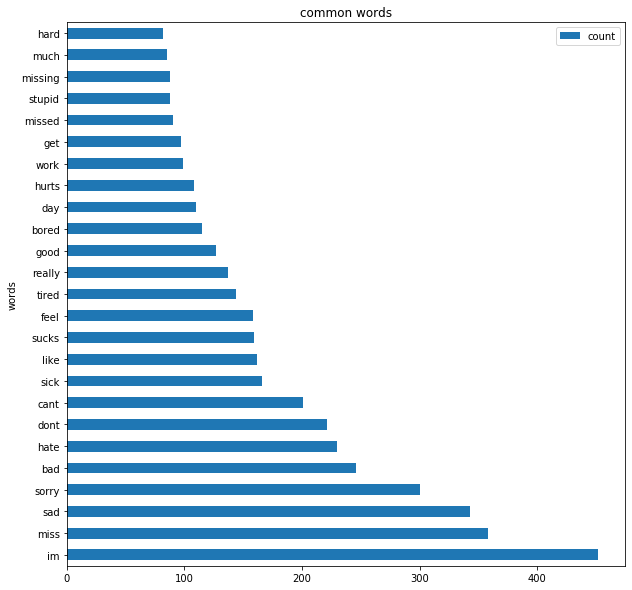

In [107]:
#for negative visualization
counter_dict_text = Counter([items_counter for items in negative_senti_dataset['words'] for items_counter in items])
database_negative = pd.DataFrame(counter_dict_text.most_common(25), columns = ['words','count'])
database_negative.plot.barh('words', 'count', title = 'common words', figsize= (10,10))

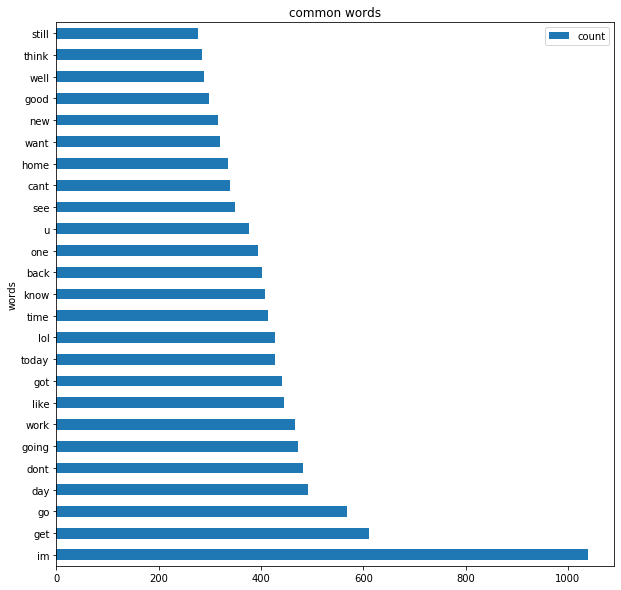

In [108]:
#for neutral visualization
counter_dict_text = Counter([items_counter for items in neutral_senti_dataset['words'] for items_counter in items])
database_neutral = pd.DataFrame(counter_dict_text.most_common(25), columns = ['words','count'])
database_neutral.plot.barh('words', 'count', title = 'common words', figsize= (10,10))

In [119]:
#modeling using NER:
test_data = pd.read_csv('test.csv')
train_data = pd.read_csv('train.csv')
submission = pd.read_csv('sample_submission.csv')

In [110]:
def save_model(output_name, nlp, new_model_name):
    nlp.meta["name"] = new_model_name
    nlp.to_disk(output_name)
    print("Saved model to", output_name)

In [148]:
def train(train_data, output_name, n_iter=20, model=None):
    if model is not None:
        nlp = spacy.load(output_name)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")
    
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "ner" not in nlp.pipe_names:
        #ner = nlp.create_pipe("ner")
        ner = nlp.add_pipe("ner", last=True)
    # otherwise, get it so we can add labels
    else:
        ner = nlp.get_pipe("ner")
    
    # add labels
    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])
            #print(ent)

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  # only train NER
        # sizes = compounding(1.0, 4.0, 1.001)
        # batch up the examples using spaCy's minibatch
        if model is None:
            nlp.begin_training()
        else:
            nlp.resume_training()
            
        
        for iterations in tqdm(range(n_iter)):
            random.shuffle(train_data)
            batches = minibatch(train_data, size=compounding(4.0, 500.0, 1.001))
            losses = {}
            for batch in batches:
                for text, annotations in batch:
                    doc = nlp.make_doc(text)
                    example = Example.from_dict(doc, annotations)
                    # Update the model
                    nlp.update([example], losses=losses, drop=0.5)
            print("Losses", losses)
#         for itn in tqdm(range(n_iter)):
#             random.shuffle(train_data)
#             batches = minibatch(train_data, size=compounding(4.0, 500.0, 1.001))    
#             losses = {}
#             for batch in batches:
#                 texts, annotations = zip(*batch)
#                 nlp.update(texts,  # batch of texts
#                             annotations,  # batch of annotations
#                             drop=0.5,   # dropout - make it harder to memorise data
#                             losses=losses, 
#                             )
                 #print("Losses", losses)
    save_model(output_name, nlp, 'st_ner')

In [116]:
def get_training_data(sentiment):
    result_data = []
    for index, row in train_data.iterrows():
        if row.sentiment == sentiment:
            selected_text = row.selected_text
            text = row.text
            start = text.find(selected_text)
            end = start + len(selected_text)
            result_data.append((text, {"entities": [[start, end, 'selected_text']]}))
    return result_data

In [162]:
sentiment = 'positive'
output_name = 'model_positive'
result_data = get_training_data(sentiment)
train(result_data, output_name, n_iter=3, model=None)



  0%|          | 0/3 [00:00<?, ?it/s]

Created blank 'en' model




 33%|███▎      | 1/3 [04:30<09:01, 270.50s/it]

Losses {'ner': 13398.220178324857}




 67%|██████▋   | 2/3 [09:34<04:40, 280.53s/it]

Losses {'ner': 12686.801283134011}




100%|██████████| 3/3 [14:25<00:00, 288.64s/it]

Losses {'ner': 12717.409597689344}
Saved model to model_positive


In [150]:
sentiment = 'negative'
output_name = 'model_negative'
result_data = get_training_data(sentiment)
train(result_data, output_name, n_iter=3, model=None)




  0%|          | 0/3 [00:00<?, ?it/s]

Created blank 'en' model




 33%|███▎      | 1/3 [04:17<08:35, 257.98s/it]

Losses {'ner': 12978.736624243254}




 67%|██████▋   | 2/3 [09:19<04:31, 271.10s/it]

Losses {'ner': 12271.204848053527}




100%|██████████| 3/3 [13:54<00:00, 278.17s/it]

Losses {'ner': 11997.021560792817}
Saved model to model_negative


In [151]:
def predictions(text, model):
    doc = model(text)
    ent_array = []
    for ent in doc.ents:
        start = text.find(ent.text)
        end = start + len(ent.text)
        new_int = [start, end, ent.label_]
        if new_int not in ent_array:
            ent_array.append([start, end, ent.label_])
    selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
    return selected_text

In [153]:
selected_texts = []
model_pos = spacy.load('model_positive')
model_neg = spacy.load('model_negative')
        
for index, row in test_data.iterrows():
    text = row.text
    output_str = ""
    if row.sentiment == 'neutral' or len(text.split()) <= 2:
        selected_texts.append(text)
    elif row.sentiment == 'positive':
        selected_texts.append(predictions(text, model_pos))
    else:
        selected_texts.append(predictions(text, model_neg))
        
test_data['selected_text'] = selected_texts

In [159]:
test_data['diff'] = np.where(test_data['text'] != test_data['selected_text'], 1 , 0)

In [161]:
test_data[test_data['diff'] == 1]

,textID,text,sentiment,selected_text,diff
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,Good,1
13,5c1e0b61a1,"I`m in VA for the weekend, my youngest son tur...",negative,"sad,",1
15,ae93ad52a0,So hot today =_= don`t like it and i hate my ...,negative,"don`t like it and i hate my new timetable, hav...",1
18,33f19050cf,you guys didn`t say hi or answer my questions...,positive,nice,1
20,9ef44428d0,Stupid storm. No river for us tonight,negative,Stupid,1
...,...,...,...,...,...
3519,91f8e27d4c,"Yes you are, thanks Haha you do? Field of fl...",positive,thanks,1
3526,4d2de9d1af,The best thing I have ever done is carry and b...,positive,best,1
3527,0c2e7ab834,"..my mother just WON the City of Terrell, Texa...",positive,HAPPY,1
3530,416863ce47,All alone in this old house again. Thanks for...,positive,Thanks,1
